In [2]:
# Librerias utilizadas en los codigos

from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle, FancyArrowPatch
from collections import Counter
import textwrap
import os
import base64
import requests
from io import BytesIO
from dotenv import load_dotenv
from IPython.display import Image, display
from matplotlib.cm import get_cmap
from textwrap import fill
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle, FancyBboxPatch, FancyArrowPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
import matplotlib.image as mpimg

In [3]:
# Cargar los archivos necesarios
input_path = Path("../data") / "database_v5.csv"
df = pd.read_csv(input_path, low_memory=False)

In [4]:
# Cargar clave API desde .env
ruta_env = Path("../env") / "TFM_Tactics.env"
load_dotenv(dotenv_path=ruta_env)

api_key = os.getenv("OPENAI_API_KEY")

In [5]:
# Prompt generado automáticamente basado en datos
def prompt_pases_kmeans(equipo, rival, fecha, num_clusters=6, competicion="Bundesliga 2023/2024"):
    texto = f"""
Actúa como un analista táctico profesional de fútbol. A continuación se muestra un mapa con agrupaciones de pases realizados por el equipo {equipo} frente a {rival}, durante el partido jugado el {fecha} en la {competicion}.

Los pases han sido agrupados mediante el algoritmo K-Means en {num_clusters} clústeres distintos, detectando patrones repetitivos en el estilo de juego.

A partir de la imagen, responde con un informe técnico profesional que detalle:
1. Las zonas del campo con más incidencia.
2. Posibles jugadas repetidas o automatismos tácticos.
3. Peligros de previsibilidad u opciones bien explotadas.
4. Estilo de progresión del balón: vertical, lateral, mixto...
5. Recomendaciones tácticas derivadas del análisis.

Redacta en un tono técnico, claro y detallado, en no más de 8-10 líneas.
"""
    return texto

# Crear imagen de red de pases y devolver base64

def imagen_base64_kmeans_pases(df, match_id, equipo="Bayer Leverkusen", texto_ia="[Análisis táctico IA pendiente]", n_clusters=6):
    import base64
    from io import BytesIO

    fig = grafico_kmeans_pases(df, match_id, equipo=equipo, texto_ia=texto_ia, n_clusters=n_clusters)

    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)
    plt.close(fig)
    img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')

    return img_base64

# Enviar a OpenAI GPT-4o con imagen base64
def analizar_kmeans_pases(base64_image, prompt, modelo="gpt-4o"):
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    body = {
        "model": modelo,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{base64_image}"
                        }
                    },
                    {
                        "type": "text",
                        "text": prompt
                    }
                ]
            }
        ],
        "temperature": 0.7
    }

    response = requests.post(url, headers=headers, json=body)
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        raise Exception(f"Error: {response.status_code} - {response.text}")

In [6]:
def grafico_kmeans_pases(df, match_id, equipo="Bayer Leverkusen", texto_ia="[Análisis táctico IA pendiente]", n_clusters=None):

    # 1. Filtrado
    df_match = df[
        (df['match_id'] == match_id) &
        (df['team'] == equipo) &
        (df['type'] == 'Pass') &
        df['location_x'].notnull() & df['location_y'].notnull() &
        df['pass_end_location_x'].notnull() & df['pass_end_location_y'].notnull()
    ].copy()

    if df_match.empty:
        raise ValueError("No hay pases para este equipo en el partido.")

    df_match = df_match.assign(
        x_start=df_match['location_x'],
        y_start=df_match['location_y'],
        x_end=df_match['pass_end_location_x'],
        y_end=df_match['pass_end_location_y']
    )

    X = df_match[['x_start', 'y_start', 'x_end', 'y_end']].values

    # 2. Clustering
    if n_clusters is None:
        inertias = []
        max_k = min(10, len(X))
        for k in range(2, max_k + 1):
            model = KMeans(n_clusters=k, random_state=0).fit(X)
            inertias.append(model.inertia_)

        best_k = 2
        if len(inertias) > 2:
            diff = np.diff(inertias)
            ddiff = np.diff(diff)
            if len(ddiff) > 0:
                best_k = np.argmin(ddiff) + 2
    else:
        best_k = n_clusters

    kmeans = KMeans(n_clusters=best_k, random_state=0).fit(X)
    df_match['cluster'] = kmeans.labels_

    # 3. Zona con más pases
    zona_width = 120 / best_k
    df_match['zona_campo'] = (df_match['x_start'] // zona_width).astype(int)
    zona_mas_usada = df_match['zona_campo'].value_counts().idxmax()

    cmap = get_cmap('tab10')
    color_cluster = cmap(zona_mas_usada % 10)

    # 4. Información contextual
    info = df[df['match_id'] == match_id].dropna(subset=[
        'home_team', 'away_team', 'home_score', 'away_score', 'match_date'
    ]).iloc[0]

    home, away = info['home_team'], info['away_team']
    fecha = str(info['match_date'])
    minuto_final = df_match['minute'].max()
    segundo_final = int(df_match[df_match['minute'] == minuto_final]['second'].max())

    # 5. Crear figura
    fig = plt.figure(figsize=(16, 10), facecolor='white')
    gs = fig.add_gridspec(3, 3, width_ratios=[3, 0.1, 1.2], height_ratios=[4, 1.9, 0.2])
    ax1, ax2, ax3 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0:2, 2]), fig.add_subplot(gs[1, 0])
    bg_ax = fig.add_axes([0, 0, 1, 1], zorder=-1)
    bg_ax.axis("off")
    bg_ax.add_patch(FancyBboxPatch((0, 0), 1, 1, transform=fig.transFigure,
                                   boxstyle="round,pad=0.01", facecolor='white',
                                   edgecolor="black", linewidth=1.5, zorder=-1))
    for ax in [ax1, ax2, ax3]: ax.set_facecolor('white')
    ax3.set_facecolor('lightgrey')
    ax2.axis('off')
    ax3.axis('off')

    # 6. Campo y clusters
    Pitch(pitch_type='statsbomb', line_color='black').draw(ax=ax1)
    for cluster_id in range(best_k):
        df_c = df_match[df_match['cluster'] == cluster_id]
        ax1.quiver(
            df_c['x_start'], df_c['y_start'],
            df_c['x_end'] - df_c['x_start'], df_c['y_end'] - df_c['y_start'],
            angles='xy', scale_units='xy', scale=1, color=cmap(cluster_id % 10),
            alpha=0.6, width=0.002, headwidth=3, headlength=4, zorder=2
        )

    ax1.set_title(f"{home} vs {away} - K-Means de pases (k={best_k})", fontsize=14, weight='bold')

    # 7. Panel marcador y tabla
    home_team = df_match['home_team'].iloc[0]
    away_team = df_match['away_team'].iloc[0]
    minuto_final = df_match['minute'].max()
    segundo_final = int(df_match[df_match['minute'] == minuto_final]['second'].max())

    if minuto_final > 90:
        texto_periodo = "Final del partido"
    elif minuto_final > 45:
        texto_periodo = "Segunda mitad"
    else:
        texto_periodo = "Primera mitad"

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.text(0.5, 0.95, fecha, ha="center", fontsize=10, weight='bold')
    ax2.text(0.5, 0.91, texto_periodo, ha="center", fontsize=10)
    ax2.text(0.5, 0.88, f"{minuto_final}:{segundo_final:02d}", ha="center", fontsize=22, weight='bold')
    ax2.add_patch(Rectangle((0.35, 0.82), 0.1, 0.05, color='black'))
    ax2.add_patch(Rectangle((0.55, 0.82), 0.1, 0.05, color='black'))
    ax2.text(0.4, 0.845, str(info['home_score']), color='white', ha='center', va='center', fontsize=16)
    ax2.text(0.6, 0.845, str(info['away_score']), color='white', ha='center', va='center', fontsize=16)
    ax2.text(0.01, 0.81, '\n'.join(textwrap.wrap(home_team, width=15)), color="red", fontsize=10, ha="left", weight="bold")
    ax2.text(0.99, 0.81, '\n'.join(textwrap.wrap(away_team, width=15)), color="blue", fontsize=10, ha="right", weight="bold")

    # 8. Tabla de métricas
    total_pases = len(df_match)
    distancias = np.sqrt((df_match['x_end'] - df_match['x_start'])**2 + (df_match['y_end'] - df_match['y_start'])**2)
    distancia_media = distancias.mean()
    pases_adelante = (df_match['x_end'] > df_match['x_start']).sum()
    porcentaje_adelante = 100 * pases_adelante / total_pases
    top_pasador = df_match['player'].value_counts().idxmax()
    top_receptor = df_match['pass_recipient'].value_counts().idxmax()

    fila_y = 0.68
    filas = [
        ("Total de pases:", total_pases),
        ("Distancia media:", f"{distancia_media:.1f} m"),
        ("Pases hacia adelante:", f"{porcentaje_adelante:.1f}%"),
        ("Jugador con más pases:", top_pasador),
        ("Jugador más conectado:", top_receptor),
        ("Zona con más pases:", "")
    ]

    for i, (label, val) in enumerate(filas):
        color_fondo = 'lightgrey' if i % 2 == 0 else 'white'
        ax2.add_patch(Rectangle((0.01, fila_y), 0.98, 0.045, color=color_fondo))
        ax2.text(0.02, fila_y + 0.025, label, fontsize=9, weight='bold', va='center')

        if label == "Zona con más pases:":
            ax2.add_patch(Circle((0.955, fila_y + 0.025), 0.012, color=color_cluster, transform=ax2.transAxes, clip_on=False))
        else:
            wrapped_val = "\n".join(textwrap.wrap(str(val), width=20))
            ax2.text(0.98, fila_y + 0.025, wrapped_val, fontsize=9, va='center', ha='right')

        fila_y -= 0.05

    # 9. Panel IA
    texto_ia = "\n".join([fill(line.strip(), width=112) for line in texto_ia.splitlines()]).replace("**", "")
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.add_patch(Rectangle((0, 0), 1, 1, transform=ax3.transAxes, color="lightgrey",
                            zorder=0, linewidth=1.2, edgecolor="black"))
    ax3.text(0.05, 0.95, "Análisis táctico IA", fontsize=10, weight="bold", va="top")
    ax3.text(0.05, 0.82, texto_ia, fontsize=8, va="top", ha="left", linespacing=1, wrap=True, family="monospace")

    fig.subplots_adjust(wspace=0.03, hspace=0.001, top=0.98, bottom=0.02)    
    return fig

In [10]:
def analisis_kmeans_pases_completo(df, match_id, equipo="Bayer Leverkusen", n_clusters=6):
    # Validación y extracción de información del partido
    try:
        info = df.loc[
            (df['match_id'] == match_id) &
            df['home_team'].notnull() &
            df['away_team'].notnull() &
            df['match_date'].notnull()
        ].iloc[0]
    except IndexError:
        raise ValueError("Información del partido no encontrada para el match_id proporcionado.")

    home, away = info['home_team'], info['away_team']
    rival = away if equipo == home else home
    fecha = str(info['match_date'])

    # Imagen preliminar con placeholder de IA
    img_base64 = imagen_base64_kmeans_pases(
        df, match_id, equipo,
        texto_ia="[Análisis táctico IA pendiente]",
        n_clusters=n_clusters
    )

    # Crear prompt táctico y enviar a GPT
    prompt = prompt_pases_kmeans(equipo, rival, fecha, num_clusters=n_clusters)
    texto_ia = analizar_kmeans_pases(img_base64, prompt)

    # Crear gráfico final con texto IA
    fig = grafico_kmeans_pases(df, match_id, equipo=equipo,
                                           texto_ia=texto_ia, n_clusters=n_clusters)

    return fig, texto_ia, prompt

C:\Users\blope\AppData\Local\Temp\ipykernel_25040\1367342372.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')
C:\Users\blope\AppData\Local\Temp\ipykernel_25040\1367342372.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')



Actúa como un analista táctico profesional de fútbol. A continuación se muestra un mapa con agrupaciones de pases realizados por el equipo Bayer Leverkusen frente a RB Leipzig, durante el partido jugado el 2023-08-19 en la Bundesliga 2023/2024.

Los pases han sido agrupados mediante el algoritmo K-Means en 6 clústeres distintos, detectando patrones repetitivos en el estilo de juego.

A partir de la imagen, responde con un informe técnico profesional que detalle:
1. Las zonas del campo con más incidencia.
2. Posibles jugadas repetidas o automatismos tácticos.
3. Peligros de previsibilidad u opciones bien explotadas.
4. Estilo de progresión del balón: vertical, lateral, mixto...
5. Recomendaciones tácticas derivadas del análisis.

Redacta en un tono técnico, claro y detallado, en no más de 8-10 líneas.



C:\Users\blope\AppData\Local\Temp\ipykernel_25040\1367342372.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


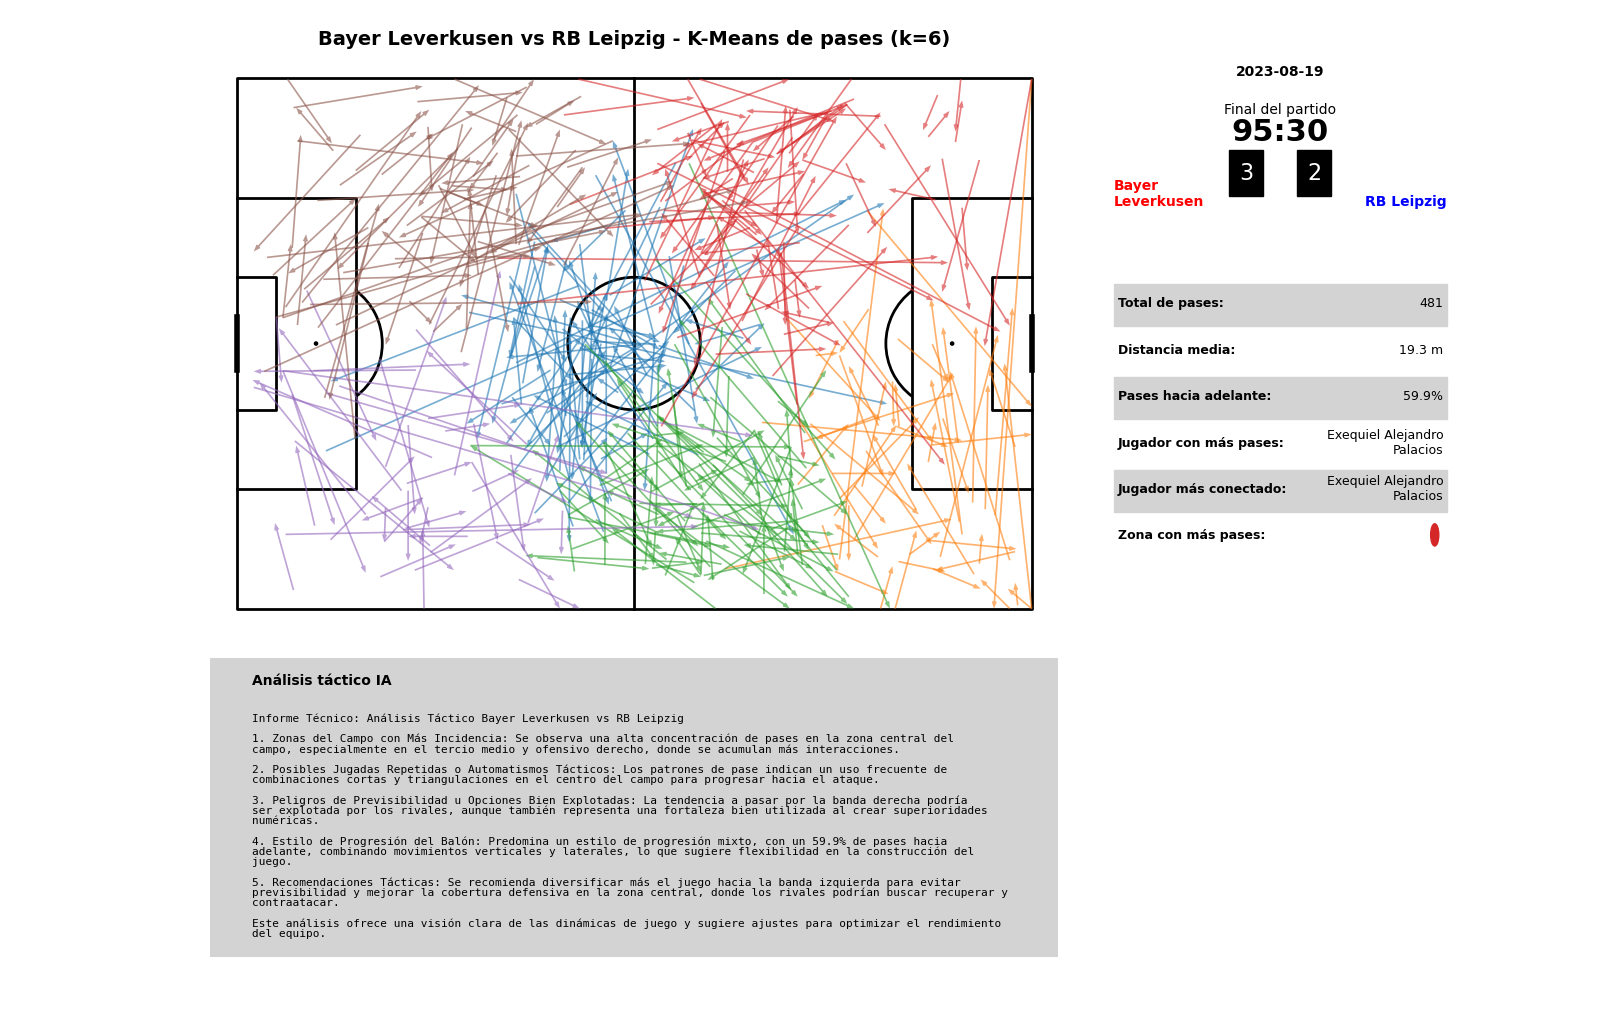

In [14]:
match_id = 3895052
equipo = "Bayer Leverkusen"

fig, texto_ia, prompt = analisis_kmeans_pases_completo(df, match_id=match_id, equipo=equipo)
# Crear ruta de salida
output_path = Path("../figs/kmeans_pases") / f"kmeans_pases_{match_id}.png"
output_path.parent.mkdir(parents=True, exist_ok=True)

fig.savefig(output_path, dpi=300, bbox_inches='tight')

print(prompt)

img_base64 = imagen_base64_kmeans_pases(df, match_id=match_id, equipo=equipo)

output_path = Path("../figs/kmeans_pases") / f"imagen_base64_kmeans_pases_{match_id}.png"
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "wb") as f:
    f.write(base64.b64decode(img_base64))